In [8]:
import mne
import matplotlib.pyplot as plt
import numpy as np
from datasets import concatenate_datasets,load_dataset

In [9]:
ds = load_dataset("Alljoined/05_125")

In [10]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['EEG', 'subject_id', 'session', 'block', 'trial', '73k_id', 'coco_id', 'curr_time'],
        num_rows: 34354
    })
    test: Dataset({
        features: ['EEG', 'subject_id', 'session', 'block', 'trial', '73k_id', 'coco_id', 'curr_time'],
        num_rows: 8716
    })
})


In [11]:
#Combining Dataset
dataset = concatenate_datasets([ds['train'], ds['test']])
print(dataset)

Dataset({
    features: ['EEG', 'subject_id', 'session', 'block', 'trial', '73k_id', 'coco_id', 'curr_time'],
    num_rows: 43070
})


In [12]:
eeg_sample = dataset[8]['EEG']
if isinstance(eeg_sample, list) or isinstance(eeg_sample, np.ndarray):
    print(np.array(eeg_sample).shape)


(64, 334)


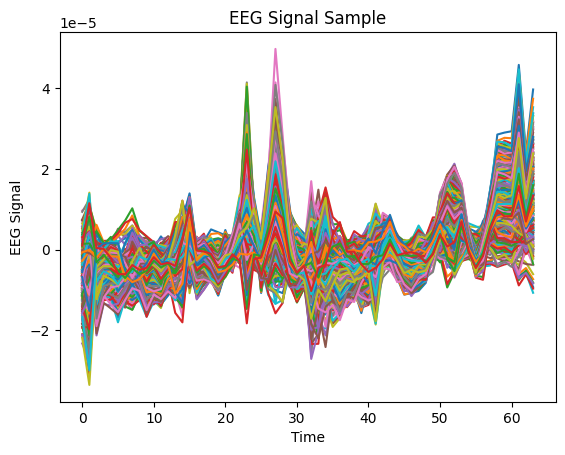

In [13]:
# Visualize EEG Data (If It’s a Time Series)
eeg_sample = dataset[4]["EEG"]
plt.plot(eeg_sample)
plt.xlabel("Time")
plt.ylabel("EEG Signal")
plt.title("EEG Signal Sample")
plt.show()


In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt

# Define the Butterworth bandpass filter function
def bandpass_filter(data, lowcut=1.0, highcut=50.0, fs=250, order=4):
    """
    Apply a Butterworth bandpass filter to the input EEG data.

    Parameters:
    - data: numpy array (1D or 2D) signal.
    - lowcut: lower frequency cutoff in Hz.
    - highcut: higher frequency cutoff in Hz.
    - fs: sampling frequency in Hz.
    - order: order of the filter.

    Returns:
    - filtered_data: filtered signal with same shape as input.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    # Create Butterworth bandpass filter coefficients
    b, a = butter(order, [low, high], btype='band')

    # Apply zero-phase filtering
    filtered_data = filtfilt(b, a, data, axis=0)
    return filtered_data

# Function to apply the filter to each record's "EEG" field
def apply_filter_to_record(example):
    """
    Apply the bandpass filter to the "EEG" field of a record while preserving other fields.

    Parameters:
    - example: A dictionary containing the record (e.g., EEG, subject_id, session, etc.).

    Returns:
    - example: The modified dictionary with filtered EEG data and all other fields preserved.
    """
    # Convert the EEG field to a NumPy array
    eeg_array = np.array(example['EEG'])

    # Apply the bandpass filter
    filtered_eeg = bandpass_filter(eeg_array, lowcut=1.0, highcut=50.0, fs=250, order=4)

    # Update the EEG field with the filtered data (convert back to list if needed)
    example['EEG'] = filtered_eeg.tolist()

    # Return the modified record with all fields preserved
    return example

filtered_dataset = dataset.map(apply_filter_to_record)


Parameter 'function'=<function apply_filter_to_record at 0x169d913f0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Map: 100%|██████████| 43070/43070 [08:39<00:00, 82.96 examples/s]


In [15]:
# Optionally, you can check a record to see the change
print(filtered_dataset[0]["subject_id"])

6


In [16]:
import os
import json

# Define the save directories
eeg_save_dir = "../data/EEG"
metadata_save_dir = "../data/metadata"

# Create directories if they don't exist
os.makedirs(eeg_save_dir, exist_ok=True)
os.makedirs(metadata_save_dir, exist_ok=True)

# Save each record as separate files in their respective folders
for i, record in enumerate(filtered_dataset):
    # Save the filtered EEG data in the EEG folder
    np.save(os.path.join(eeg_save_dir, f"eegSample_{i}.npy"), np.array(record['EEG']))

    # Save metadata (e.g., subject_id, session, etc.) in the metadata folder
    metadata = {key: value for key, value in record.items() if key != 'EEG'}
    with open(os.path.join(metadata_save_dir, f"metaData_{i}.json"), "w") as f:
        json.dump(metadata, f)

print(f"Filtered EEG data saved to {eeg_save_dir}")
print(f"Metadata saved to {metadata_save_dir}")

Filtered EEG data saved to ../data/EEG
Metadata saved to ../data/metadata
